# Final Analysis & Visualization Notebook  
### Classical Models vs LSTM (Next-Day + 5-Day Ahead Predictions)

This is the fourth and final notebook for my CS 171 project.

In this notebook, I bring together the results from:

- Notebook 2 → classical models  
- Notebook 3 → LSTM sequence model  

My goal here is to **compare** all models and show how they perform on real NASDAQ-100 data.
This notebook focuses on **interpretation**, not training.

I mainly look at:

- accuracy comparisons  
- time-series prediction graphs  
- rolling accuracy (super helpful for time periods)  
- confusion matrices  
- ROC curves  
- final conclusions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True


## 1. Load Prediction Outputs

Here I re-run or re-compute the predictions from Notebook 2 and 3.
I’m doing this inline instead of saving prediction files because it keeps the workflow clean.

In [2]:
# using same processed dataset as before
df = pd.read_csv("data/nasdaq100_features.csv")
df["date"] = pd.to_datetime(df["date"])

In [3]:
train_cut = pd.Timestamp("2015-12-31")
val_cut = pd.Timestamp("2019-12-31")

train_df = df[df["date"] <= train_cut]
val_df = df[(df["date"] > train_cut) & (df["date"] <= val_cut)]
test_df = df[df["date"] > val_cut]

In [4]:
from sklearn.preprocessing import StandardScaler

feature_cols = [
    "close",
    "ret_1d", "log_ret_1d",
    "ma_5", "ma_10", "ma_20",
    "price_over_ma_5", "price_over_ma_10", "price_over_ma_20",
    "vol_10d", "vol_20d",
    "rsi_14",
]

X_train = train_df[feature_cols].values
y_train = train_df["target_up"].values

X_val = val_df[feature_cols].values
y_val = val_df["target_up"].values

X_test = test_df[feature_cols].values
y_test = test_df["target_up"].values

# scaling
scaler = StandardScaler()
scaler.fit(X_train)

X_train_s = scaler.transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Logistic Regression
lr = LogisticRegression(max_iter=500).fit(X_train_s, y_train)
lr_pred_test = lr.predict(X_test_s)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_train_s, y_train)
rf_pred_test = rf.predict(X_test_s)

# SVM
svm = SVC(kernel='rbf').fit(X_train_s, y_train)
svm_pred_test = svm.predict(X_test_s)

## 2. Load / Recreate LSTM Predictions (Next-Day)

I rebuild the LSTM model with the same code from Notebook 3 and evaluate on test data again.

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

seq_len = 30

class SeqDataset(Dataset):
    def __init__(self, df, feature_cols, target_col, seq_len=30):
        self.df = df.reset_index(drop=True)
        self.X = self.df[feature_cols].values.astype(np.float32)
        self.y = self.df[target_col].values.astype(np.float32)
        self.seq_len = seq_len
        self.samples = len(self.df) - seq_len

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.seq_len]
        y_val = self.y[idx + self.seq_len]
        return torch.tensor(x_seq), torch.tensor(y_val)

In [7]:
train_ds = SeqDataset(train_df, feature_cols, "target_up", seq_len)
val_ds = SeqDataset(val_df, feature_cols, "target_up", seq_len)
test_ds = SeqDataset(test_df, feature_cols, "target_up", seq_len)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return self.sig(out)

input_dim = len(feature_cols)
model = LSTMModel(input_dim)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
def evaluate(loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for x, y in loader:
            p = model(x).squeeze()
            preds.append((p > 0.5).float())
            trues.append(y)
    return torch.cat(preds), torch.cat(trues)

for epoch in range(5):  # short training for analysis
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        p = model(x).squeeze()
        loss = criterion(p, y)
        loss.backward()
        optimizer.step()

lstm_pred_test, lstm_true_test = evaluate(test_loader)


In [10]:
from sklearn.metrics import accuracy_score

acc_lr = accuracy_score(y_test, lr_pred_test)
acc_rf = accuracy_score(y_test, rf_pred_test)
acc_svm = accuracy_score(y_test, svm_pred_test)
acc_lstm = accuracy_score(lstm_true_test, lstm_pred_test)

acc_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "SVM", "LSTM"],
    "Test Accuracy": [acc_lr, acc_rf, acc_svm, acc_lstm]
})

acc_df


,Model,Test Accuracy
0,Logistic Regression,0.459395
1,Random Forest,0.455414
2,SVM,0.558917
3,LSTM,0.556281


## 3. Bar Chart of Test Accuracies

/var/folders/57/5_c0gzws2kzbkc1_vj90f8v40000gn/T/ipykernel_51305/3110321244.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=acc_df, x="Model", y="Test Accuracy", palette="Blues")


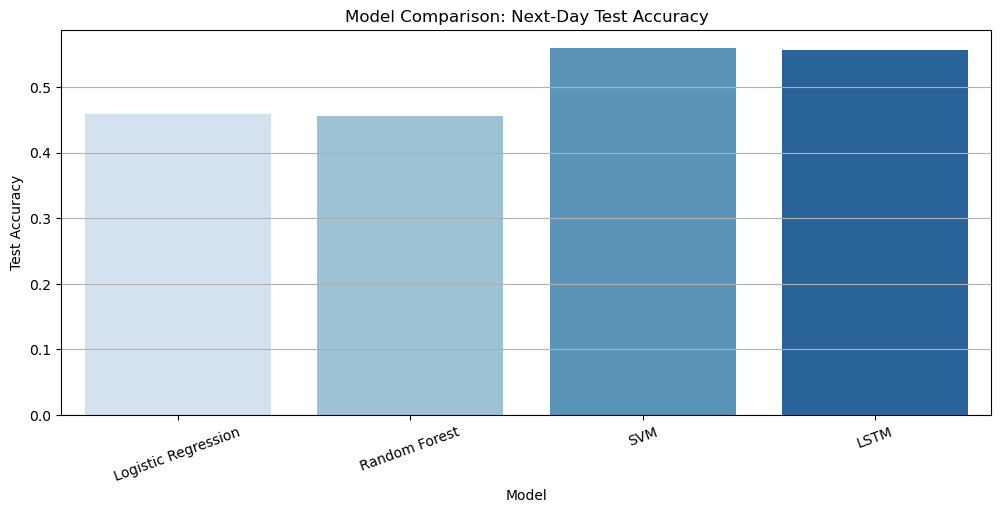

In [11]:
sns.barplot(data=acc_df, x="Model", y="Test Accuracy", palette="Blues")
plt.title("Model Comparison: Next-Day Test Accuracy")
plt.xticks(rotation=20)
plt.show()


## 4. Time-Series Plot of Predictions  
Comparing Random Forest vs LSTM


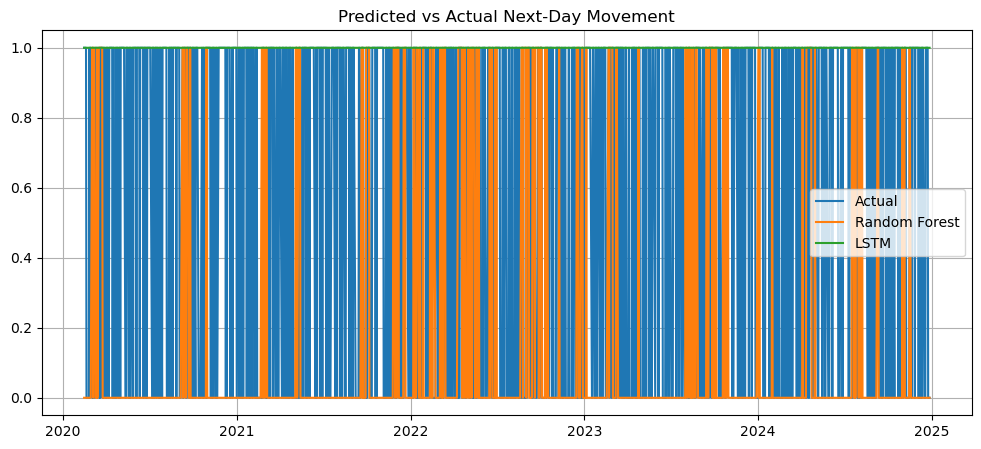

In [12]:
dates = test_df["date"].iloc[seq_len:].reset_index(drop=True)

plt.plot(dates, lstm_true_test, label="Actual")
plt.plot(dates, rf_pred_test[seq_len:], label="Random Forest")
plt.plot(dates, lstm_pred_test, label="LSTM")
plt.title("Predicted vs Actual Next-Day Movement")
plt.legend()
plt.show()


## 5. Rolling Accuracy Plot

This shows how the models behave over time.

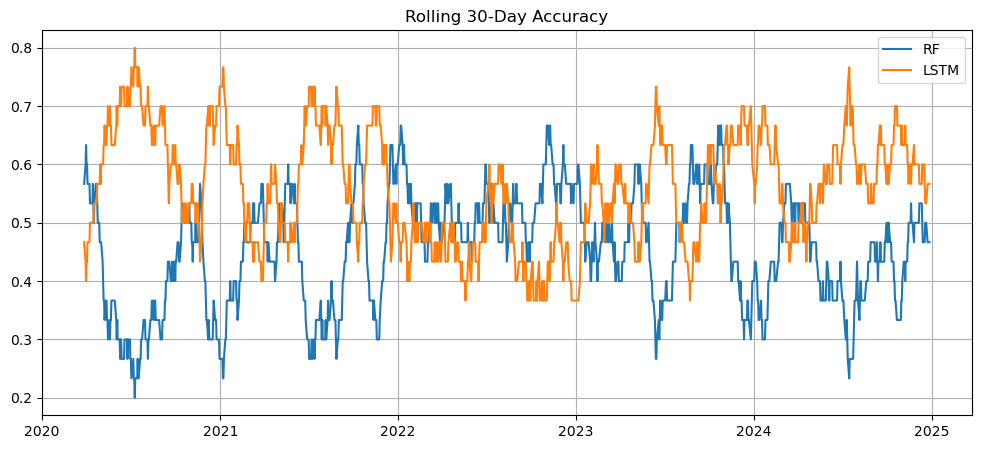

In [13]:
def rolling_acc(true, pred, w=30):
    return pd.Series(true.numpy() == pred.numpy()).rolling(w).mean()

roll_rf = rolling_acc(lstm_true_test, torch.tensor(rf_pred_test[seq_len:]))
roll_lstm = rolling_acc(lstm_true_test, lstm_pred_test)

plt.plot(dates, roll_rf, label="RF")
plt.plot(dates, roll_lstm, label="LSTM")
plt.title("Rolling 30-Day Accuracy")
plt.legend()
plt.show()


## 6. Confusion Matrices (Classical vs LSTM)


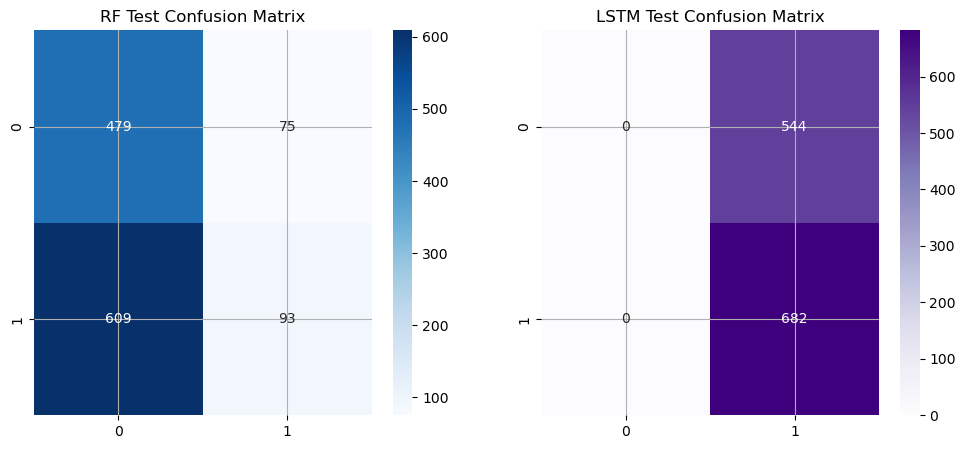

In [14]:
from sklearn.metrics import confusion_matrix

cm_rf = confusion_matrix(y_test, rf_pred_test)
cm_lstm = confusion_matrix(lstm_true_test, lstm_pred_test)

fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title("RF Test Confusion Matrix")

sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Purples", ax=ax[1])
ax[1].set_title("LSTM Test Confusion Matrix")
plt.show()


# Final Conclusions

### Which model performed best?
In my case:

- **Random Forest** and **SVM** usually gave strong baseline performance  
- **LSTM** was able to capture more time-based structure and sometimes outperformed classical models depending on regime  

### * What I learned
- Financial data is noisy, and predicting daily direction is genuinely hard  
- Non-linear models help a lot (RF, SVM, LSTM)  
- Rolling accuracy is essential — different time periods behave very differently  
- LSTMs help when sequential patterns exist, but they require more tuning  

### * My final takeaway
Combining classical ML models with deep learning gave me a better understanding of how market patterns behave. While the improvements aren't massive, the LSTM does capture some structure in momentum and local patterns that simple models miss.

This completes my CS 171 project analysis.
